# First try
Let's see if we can get a simple Neural Network running in Julia. This will give us a place to start when it comes to more sophisticated Neural Network architecture performances, as well as exploring timing differences between Julia and Python.

If there's a package that hasn't been installed yet, the syntax is:
```julia
using Pkg
Pkg.add("PackageName"); 
```

In [371]:
using CUDA
using DataFrames
using Flux
import JSON
using Lathe.preprocess: TrainTestSplit
using LinearAlgebra
using Plots
using StatsBase
using StatsPlots

include("helpers.jl")

readjsonsfromdirectory (generic function with 1 method)

## Getting data together

In [ ]:
# get data
data_raw = JSON.parsefile("data/dataset_0.json")["samples"];

In [3]:
# separate features and responses, convert types, build DataFrames
tofloat((k,v)) = k => parse(Float64, v)

indexes = Vector{String}()

x_df = DataFrame(corx=Float64[], cory=Float64[], I0=Float64[], rmst=Float64[], rmsx=Float64[], rmsy=Float64[])
for sample in data_raw
    features = Dict{String, Any}(sample[2]["dvar"])
    features_formatted = Dict{String, Float64}(Iterators.map(tofloat, pairs(features)))
    push!(x_df, features_formatted)
    push!(indexes, sample[1])
end

y_df = DataFrame(
    DE=Float64[], EMIT_S=Float64[], EMIT_X=Float64[], EMIT_Y=Float64[],
    RMS_PS=Float64[], RMS_PX=Float64[], RMS_PY=Float64[],
    RMS_S=Float64[], RMS_X=Float64[], RMS_Y=Float64[],
    XPX=Float64[], YPY=Float64[], ZPZ=Float64[]
)
for (i, sample) in enumerate(data_raw)
    responses = Dict{String, Any}(sample[2]["obj"])
    responses_formatted = Dict{String, Float64}(Iterators.map(tofloat, pairs(responses)))
    push!(y_df, responses_formatted)
    @assert(sample[1] == indexes[i])
end

In [4]:
first(x_df, 5)

,corx,cory,I0,rmst,rmsx,rmsy
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0927206,-0.145995,2.64436,0.000161705,0.00491312,0.000224465
2,0.223842,-0.339065,6.82193,0.00023144,0.0046246,0.000588258
3,-0.224052,0.4214,3.96535,0.000214727,0.00142451,0.000174713
4,0.297364,-0.4615,7.64486,0.000222002,0.00397011,0.000316593
5,-0.241493,-0.496557,5.88497,0.000265118,0.00325739,0.000487906


In [5]:
first(y_df, 5)

,DE,EMIT_S,EMIT_X,EMIT_Y,RMS_PS,RMS_PX,RMS_PY
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,8.1042,8.09111e-5,0.000179568,0.000114043,0.0109415,0.0382563,0.0273862
2,12.3045,0.00012992,0.000165861,0.000186837,0.0166114,0.0392669,0.0283264
3,11.5762,0.000140009,5.88273e-5,0.000200963,0.0156272,0.0404457,0.0311757
4,14.9774,0.000173924,0.000142209,0.00025747,0.0202188,0.0398521,0.0303639
5,12.2154,0.000130465,0.00011881,0.000189254,0.016491,0.0397241,0.0286817


In [6]:
# scaler
mutable struct MinMaxScaler
    data_min::Float64
    data_max::Float64
end

function fit!(scaler, data)
    scaler.data_min = minimum(data); scaler.data_max = maximum(data)
end

function transform(scaler, data)
    [2*(d - scaler.data_min)/(scaler.data_max - scaler.data_min) - 1 for d in data]
end

function inverse_transform(scaler, data_scaled)
    [0.5*(scaler.data_max - scaler.data_min)*(d_s + 1) + scaler.data_min for d_s in data_scaled]
end

function fit_transform(data)
    scaler = MinMaxScaler(0., 0.)
    fit!(scaler, data)
    transform(scaler, data)
end

# sanity checking
data_test = [1., 2., 3., 4., 5.]
scaler_test = MinMaxScaler(0., 0.)
fit!(scaler_test, data_test)
data_test_scaled = transform(scaler_test, data_test)
@assert(maximum(data_test_scaled) == 1.0)
@assert(minimum(data_test_scaled) == -1.0)
@assert(maximum(data_test) == maximum(inverse_transform(scaler_test, data_test_scaled)))
@assert(minimum(data_test) == minimum(inverse_transform(scaler_test, data_test_scaled)))

In [7]:
# scaling data
x_scaled_df = hcat(DataFrame.(colname=>fit_transform(x_df[!, colname]) for colname in names(x_df))...)
y_scaled_df = hcat(DataFrame.(colname=>fit_transform(y_df[!, colname]) for colname in names(y_df))...)

@assert(all(maximum(x_scaled_df[!, colname]) == 1. for colname in names(x_scaled_df)))
@assert(all(minimum(x_scaled_df[!, colname]) == -1. for colname in names(x_scaled_df)))

In [8]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [9]:
# format to arrays
x_train = Matrix(x_train_df); x_test = Matrix(x_test_df);
y_train = Matrix(y_train_df); y_test = Matrix(y_test_df);

## Building and training the neural net

Let's discuss the loss functions briefly:

**Mean Squared Error (`mse`).** For our true values $\{\mathbf{y}_i\}_{i=1}^N$, and our predicted values $\{\hat{\mathbf{y}}_i\}_{i=1}^N$, for $\mathbf{y}_i, \hat{\mathbf{y}}_i \in \mathbb{R}^d\ \forall i$:

$$ \mathcal{L}_{\textrm{MSE}} (\{ \mathbf{y}_i \}_{i=1}^N,\{ \hat{\mathbf{y}}_i \}_{i=1}^N) = \frac{1}{N} \sum_{i=1}^N \| \mathbf{y}_i - \hat{\mathbf{y}}_i \|_2^2 $$

For L2-norm $\| \mathbf{v} \|_2 \equiv \sqrt{v_1^2 + v_2^2 + \dots}$.

**Mean Absolute Error (`mae`).** Using the same notation,

$$ \mathcal{L}_{\textrm{MAE}} (\{ \mathbf{y}_i \}_{i=1}^N,\{ \hat{\mathbf{y}}_i \}_{i=1}^N) = \frac{1}{N} \sum_{i=1}^N \| \mathbf{y}_i - \hat{\mathbf{y}}_i \|_1 $$

For L1-norm $\| \mathbf{v} \|_1 \equiv |v_1| + |v_2| + \dots $.

**Mean Absolute Percentage Error (`mape`).** Using the same notation,

Note that MSE is differentiable, MAE is not. So training a neural network using MSE allows us to use simple gradient descent to minimize the loss function in the backpropagation steps. Using a stochastic optimizer like `ADAM` wouldn't be a bad idea if using a non-differentiable loss.

In [365]:
# some other loss functions / metrics
max_valueormachinelimit(x) = max(x, eps())

function mape(ys, ŷs)
    numerators = broadcast(abs, ys - ŷs)
    denominators = broadcast(max_valueormachinelimit, broadcast(abs, ys))
    mape = numerators ./ denominators
    return mean(mape)
end

# build the model
function neuralnetwork()
    Chain(
        Dense(6, 25, x->σ.(x)),
        Dense(25, 25, x->σ.(x)),
        Dense(25, 25, x->σ.(x)),
        Dense(25, 13)
    )
end

neuralnetwork (generic function with 1 method)

In [11]:
# organizing data into batches
batchsize = 50
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batchsize, shuffle=true);

# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM()
loss(x, y) = Flux.mse(m(x), y)

loss (generic function with 1 method)

Let's start training. Note that we can make the training process more explicit by unpacking what's under the hood of `Flux.train!(loss, Flux.params(m), data_loader, optimizer)`:

```julia
function trainmodel!(m, data_loader; epochs=epochs)
    for epoch = 1:n_epochs
        for d in data_loader
            gs = gradient(Flux.params(m)) do
                l = loss(d...)
            end
            Flux.update!(opt, Flux.params(m), gs)
        end
    end
end

trainmodel!(m, data_loader; epochs=n_epochs)
```

_Note to self: at some point we should implement early stopping to prevent overfitting_

In [12]:
# training
n_epochs = 100
training_losses = Float64[]
epochs = Int64[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=15.013705317038951
epoch 2, loss=14.634150713385417
epoch 3, loss=13.479830881769715
epoch 4, loss=9.868334796934953
epoch 5, loss=6.7192895752346935
epoch 6, loss=4.408366971400917
epoch 7, loss=2.9154427890009362
epoch 8, loss=2.148611929468555
epoch 9, loss=1.7433946390427744
epoch 10, loss=1.5342878163390705
epoch 11, loss=1.3813296243288906
epoch 12, loss=1.2529433686087936
epoch 13, loss=1.1462266383292419
epoch 14, loss=1.0521011916514444
epoch 15, loss=0.9603922835092312
epoch 16, loss=0.8855310327490428
epoch 17, loss=0.8123499133252075
epoch 18, loss=0.7399773242692966
epoch 19, loss=0.6722454640229596
epoch 20, loss=0.6116824847144496
epoch 21, loss=0.5628789150005921
epoch 22, loss=0.5144007255899803
epoch 23, loss=0.47132982717048916
epoch 24, loss=0.431307050583169
epoch 25, loss=0.4037388210146277
epoch 26, loss=0.367313728632618
epoch 27, loss=0.34148525864366513
epoch 28, loss=0.3190662088068374
epoch 29, loss=0.29380791261515166
epoch 30, loss=0.27841867

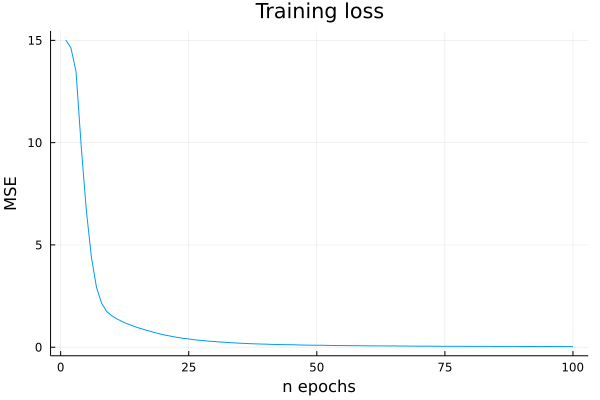

In [149]:
# plot the results
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

I define a function to compute $R^2$ for multidimensional target variables `r2score_multidim`, with similar functionality to <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html'>`sklearn.metrics.r2_score`</a>:
- `multioutput="rawvalues"` computes the $R^2$ score for each of the dimensions separately, returning a vector
- `multioutput="uniformaverage"` computes the $R^2$ score for each of the dimensions of the output separately, and averages the result uniformly
- (**TODO**) `multioutput="varianceweighted"` computes the $R^2$ score for each of the dimensions of the output separately, and then computes a weighted average with weights equal to the variance of each of the output dimensions. _This isn't needed just yet so I'll wait on implementing this_

In [133]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [134]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.997489403269587
r2 on test set: 0.9975493715311449


Recall that we can express the adjusted $R^2$, $\bar{R}^2$ in terms of our sample size $M$ and the dimensions of our input $p$:

$$ \bar{R}^2 = 1 - (1 - R^2) \frac{M - 1}{M - p - 1} $$

This extends our implementation of `r2score` and `r2score_multidim` easily.

In [143]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [148]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.997487518673017
adjustedr2 on test set: 0.9975419938237624


In [366]:
mape_train = mape(y_train, m(x_train')')
mape_test = mape(y_test, m(x_test')')
println("mape on training set: $mape_train")
println("mape on test set: $mape_test")

mape on training set: 0.21729514343377987
mape on test set: 0.08476559722175045


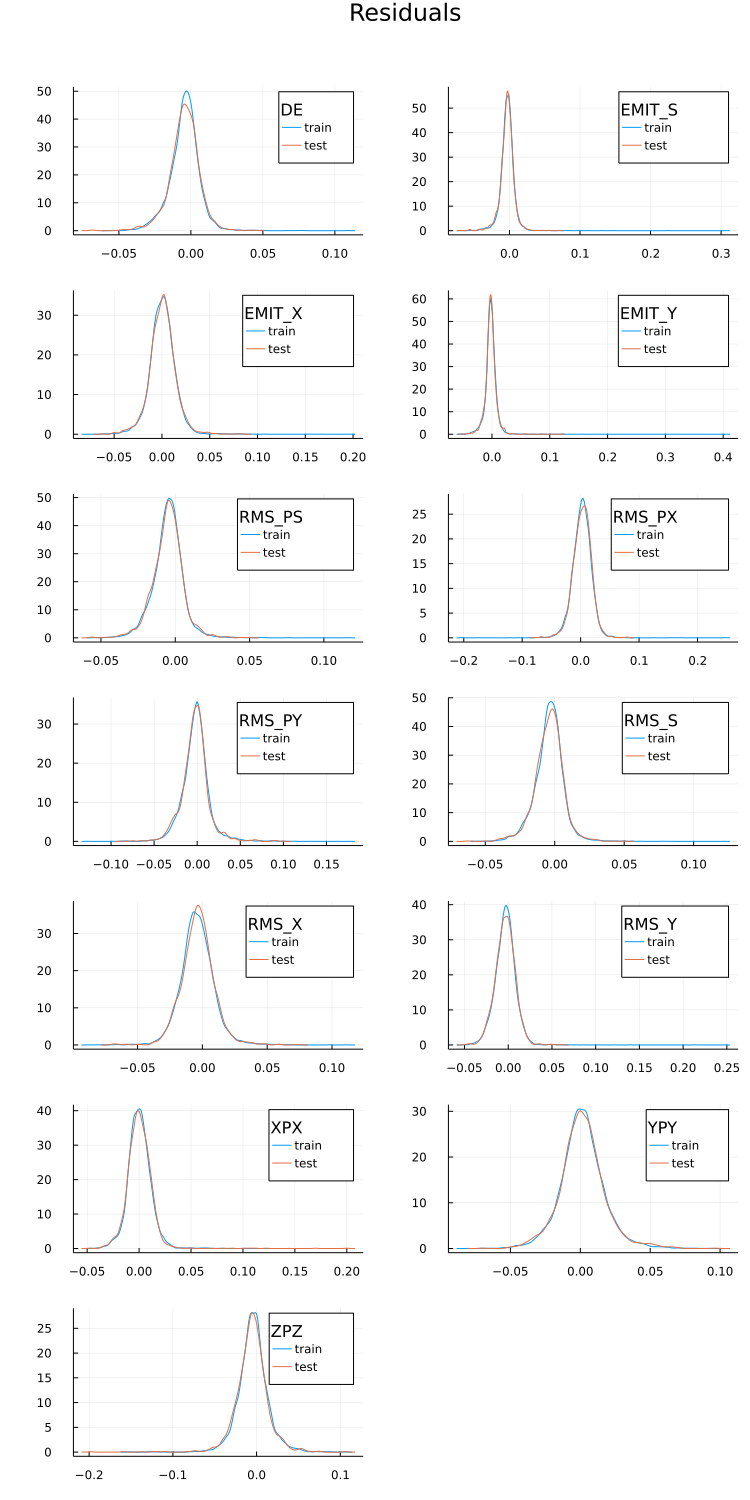

In [360]:
# plotting the residual distribution
l = @layout [grid(7,2)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 1500), plot_title="Residuals")